Цель работы: с помощью метода кластеризации попытаться улучшить регрессионную модель.  
Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Реализуем функции, которые понадобятся нам в дальнейшем. Основной интерес, конечно же, представляет функция K_means (имя дано по названию алгоритма). Хотя функция и должна разбивать множество на K кластеров, экспериментально было установлено, что часто какой-то из кластеров оказывается пустым, т.е. другие кластеры перетягивают на себя все объекты. Возможно, с этим можно как-то бороться, однако в данном случае было решено позволить алгоритму самовольничать.  
Суть алгоритма: он случайным образом образом разбиваем мн-во объектов на кластеры, затем считает у каждого кластера центр и на основании этого перетасовывает кластеры: каждый объект попадает в тот кластер, к центру которого он ближе всего. Затем процедура повторяется. Утверждается, что если есть ярко выраженная кластеризация, то алгоритм будет быстро сходится. Если же объекты хаотично разбросаны в метрическом пространстве, то, скорее всего, ничего хорошего не будет и объекты будут просто хаотически путешествовать из кластера в кластер.

In [2]:
def find_coeffs(X, y):  # обыяным МНК находим коэффициенты
    w = np.dot(np.linalg.pinv(X), y)
    return w

def msqr_err(X, w, y): # среднеквадратичная ошибка
    return np.nanmean((np.dot(X, w) - y)**2)

def K_means(K, X, iterations=50, return_clasters=True): #разбиваем мн-во объектов на К кластеров (вообще говоря, <= K)
    obj_claster = np.random.choice(np.arange(K), len(X))
    claster_centers = []
    for iteration in range(iterations):
        claster_centers.clear()
        for k in range(K):
            X_k = [X[i] for i, c in enumerate(obj_claster) if c == k]
            if len(X_k) != 0: #экспериментально установлено, что иногда от кластера "уходят" все объекты (переизбыток кластеров)
                claster_centers.append(np.mean(X_k, axis=0))
        for i, x in enumerate(X):
            min_dist = np.inf
            nearest_claster = -1
            for k in range(len(claster_centers)):
                dist = np.linalg.norm(claster_centers[k] - x)
                if dist < min_dist:
                    nearest_claster = k
                    min_dist = dist
            obj_claster[i] = nearest_claster
    if return_clasters:
        return obj_claster, claster_centers
    else:
        return claster_centers

Считаем датасет из файла.

In [3]:
data = pd.read_excel('EnergyConsumption.xls')
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,2005-01-01 00:00:00,6,00:00:00,1289.617859,-10.676569
1,2005-01-01 01:00:00,6,01:00:00,1265.573853,-12.041959
2,2005-01-01 02:00:00,6,02:00:00,1273.188232,-13.198006
3,2005-01-01 03:00:00,6,03:00:00,1279.703979,-13.999279
4,2005-01-01 04:00:00,6,04:00:00,1292.839539,-14.782819


Собственно, проведем некоторые манипуляции.

In [4]:
data.Hour = [x.hour for x in data.Hour]
data.Date = [x.toordinal()%365 for x in data.Date]
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,122,6,0,1289.617859,-10.676569
1,122,6,1,1265.573853,-12.041959
2,122,6,2,1273.188232,-13.198006
3,122,6,3,1279.703979,-13.999279
4,122,6,4,1292.839539,-14.782819


Посмтрим на графики, чтобы сделать некие предположения по поводу количества признаков. Например, видим, что потребление электричества от температуры зависит почти линейно, поэтому в признаковом описании ограничимся лишь самой температурой, не беря от нее никаких дополнительных функций.

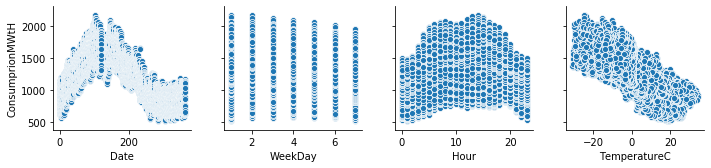

In [5]:
sns.pairplot(data, x_vars = ['Date', 'WeekDay', 'Hour', 'TemperatureC'], y_vars=['ConsumprionMWtH'])

Разобьем нашу выборку на обучающую и тестовую.

In [6]:
train_X = [[row['Date'], row['WeekDay'], row['Hour'], row['TemperatureC']] for i, row in data.iterrows() if i%5 != 0]
train_y = [row['ConsumprionMWtH'] for i, row in data.iterrows() if i%5 != 0]

test_X = [[row['Date'], row['WeekDay'], row['Hour'], row['TemperatureC']] for i, row in data.iterrows() if i%5 == 0]
test_y = [row['ConsumprionMWtH'] for i, row in data.iterrows() if i%5 == 0]

Добавим новые признаки как функции от старых.

In [7]:
train_X = [np.array([1, x[0], x[0]**2, x[0]**3, x[1], x[1]**2, x[1]**3, x[2], x[2]**2, x[2]**3, x[3]]) for x in train_X]
test_X = [np.array([1, x[0], x[0]**2, x[0]**3, x[1], x[1]**2, x[1]**3, x[2], x[2]**2, x[2]**3, x[3]]) for x in test_X]

Посчитаем веса.

In [8]:
weights = find_coeffs(train_X, train_y)

Выведем среднеквадратичную ошибку на тестовой выборке.

In [9]:
print(msqr_err(test_X, weights, test_y))

9187.464658685352


В общем-то, теперь самый волнительный момент, ради которого всё это и затевалось. Будем разбивать на кластеры и строить график. В качестве дополнительных признаков добавляем расстояние до центров кластеров. Дополнительно выводим, сколько коластеров на самом деле получилось.

2 - 2
4 - 4
6 - 5
8 - 8
10 - 9
12 - 11
14 - 9
16 - 12
18 - 15
20 - 16
22 - 13
24 - 16
26 - 15
28 - 17


Text(0.5, 0, 'Num of clasters')

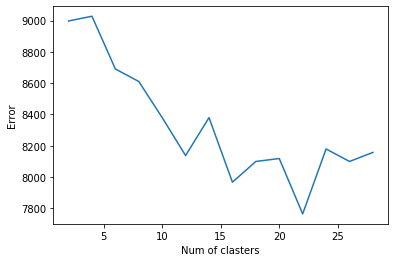

In [11]:
errs = []
for K in range(2, 30, 2):
    print(K, end=' - ')
    claster_centers = K_means(K, train_X, return_clasters=False)
    l = len(train_X[0])
    K = len(claster_centers)
    for k in range(K):
        train_X = np.column_stack((train_X, [np.linalg.norm(x[:l] - claster_centers[k]) for x in train_X]))
        test_X = np.column_stack((test_X, [np.linalg.norm(x[:l] - claster_centers[k]) for x in test_X]))
    weights = find_coeffs(train_X, train_y)
    errs.append(msqr_err(test_X, weights, test_y))
    train_X = [x[:l] for x in train_X]
    test_X = [x[:l] for x in test_X]
    print(len(claster_centers))
    
plt.plot(range(2, 30, 2), errs)
plt.ylabel('Error')
plt.xlabel('Num of clasters')

Что мы видим? Число кластеров стабилизируется в районе 16-ти. Соотвтественно, после этого числа ошибка практически перестает меняться. Но она существенно лучше, чем ошибка при обучении без использования кластеризации.  
Вывод: использование кластеров может довольно значимо повысить эффективность линейной регрессии.